In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  evaluation.core import State
from typing import Dict, List
import datetime
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from copy import deepcopy
import random
from Rushi.PPO.trainer import PPOTrainer
from Rushi.PPO.ml import PPOAgent
from Rushi.PPO.core import EarlyEnvironment, EarlyEnvs
from Rushi.PPO.utils import Logger, makeFeatures, getInvalidActionMask, getStateFeatures, getStockFeatures, interpolatorNotForDay, addPatterns
from evaluation.core import BaseStrategy
from evaluation.constants import HOLD_ACTION,BUY_ACTION,SELL_ACTION
from Rushi.PPO.constants import MAX_HOLDING, MAX_TRADE_TIME_IN_5_MINUTE, MAX_TRADE_TIME_IN_DAYS, MAX_TRADE_TIME_IN_MINUTE, MODES, minutes_5_in_day, minutes_in_day, ROLLING_WINDOW_SIZE_IN_MINUTE, ROLLING_WINDOW_SIZE_IN_5_MINUTE,end_time_5_minute, end_time_minute
from Rushi.PPO.constants import end_time_minute, end_time_5_minute
from Rushi.PPO.ppoStrategy import PPOStrategy
from evaluation.backTest import BackTest
from tqdm import tqdm
import matplotlib.dates as mdates

/home/captanlevi/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")
addPatterns(df)

total values interpolated = 1230


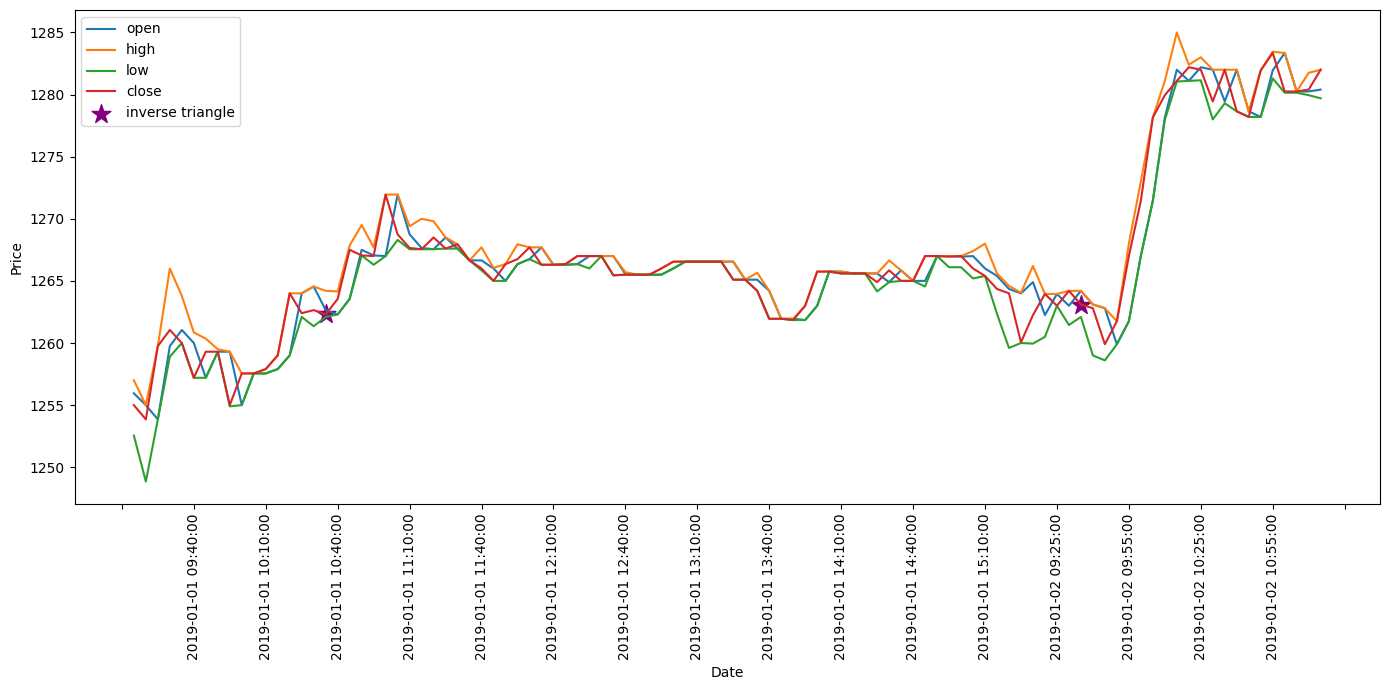

In [3]:
start = 0
end = 100

open = df.open.values[start:end]
high = df.high.values[start:end]
low = df.low.values[start:end]
close = df.close.values[start:end]
date = df.date.values[start:end]

head_shoulder = df.head_shoulder_pattern.values[start:end]
head_shoulder_marker_dates = date[head_shoulder == 1]
head_shoulder_close = close[head_shoulder == 1]

head_shoulder_inverse_marker_dates = date[head_shoulder == -1]
head_shoulder_inverse_close = close[head_shoulder == -1]

##########################################################
double_tops = df.double_pattern.values[start:end]
double_tops_marker_dates = date[double_tops == 1]
double_tops_close = close[double_tops == 1]

double_bottoms_marker_dates = date[double_tops == -1]
double_bottoms_close = close[double_tops == -1]

##############################################################
pivot_signal = df.pivot_signal.values[start:end]

pivot_higher_high_dates = date[pivot_signal == -2]
pivot_higher_high_close = close[pivot_signal == -2]

pivot_lower_low_dates = date[pivot_signal == -1]
pivot_lower_low_close = close[pivot_signal == -1]

pivot_lower_high_dates = date[pivot_signal == 1]
pivot_lower_high_close = close[pivot_signal == 1]

pivot_higher_low_dates = date[pivot_signal == 2]
pivot_higher_low_close = close[pivot_signal == 2]

##############################################################

triangle_pattern = df.triangle_pattern.values[start:end]
triangle_dates = date[triangle_pattern == 1]
triangle_close = close[triangle_pattern == 1]

inverse_triangle_dates = date[triangle_pattern == -1]
inverse_triangle_close = close[triangle_pattern == -1]

#################################################################


plt.figure(figsize=(14, 7))  # Optional: Adjust the figure size



plt.plot(date,open, label = "open")
plt.plot(date,high, label = "high")
plt.plot(date,low, label = "low")
plt.plot(date,close, label = "close")
#plt.scatter(head_shoulder_marker_dates, head_shoulder_close, color='purple', marker='*', s=200, label='Head Shoulders')
#plt.scatter(head_shoulder_inverse_marker_dates, head_shoulder_inverse_close, color='purple', marker='*', s=200, label='Inverse Head Shoulders')
#plt.scatter(double_tops_marker_dates, double_tops_close, color='purple', marker='*', s=200, label='double tops')

#plt.scatter(double_bottoms_marker_dates, double_bottoms_close, color='purple', marker='*', s=200, label='double bottoms')

"""
plt.scatter(pivot_higher_high_dates, pivot_higher_high_close, color='purple', marker='*', s=200, label='pivot higher high')
plt.scatter(pivot_lower_low_dates, pivot_lower_low_close, color='black', marker='*', s=200, label='pivot lower low')
plt.scatter(pivot_lower_high_dates, pivot_lower_high_close, color='blue', marker='*', s=200, label='pivot lower high')
plt.scatter(pivot_higher_low_dates, pivot_higher_low_close, color='maroon', marker='*', s=200, label='pivot higher low')
"""

#plt.scatter(triangle_dates, triangle_close, color='purple', marker='*', s=200, label='triangle')
plt.scatter(inverse_triangle_dates, inverse_triangle_close, color='purple', marker='*', s=200, label='inverse triangle')



plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=6))
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

#plt.plot(gea)
#plt.plot(, marker = ">")

In [8]:

close = df.close.values
normed_close = (close - close.mean())/close.std()

window_norm = (df.close - df.close.rolling(ROLLING_WINDOW_SIZE_IN_5_MINUTE).mean())/(df.close.rolling(ROLLING_WINDOW_SIZE_IN_5_MINUTE).std())
window_norm = window_norm.values[ROLLING_WINDOW_SIZE_IN_5_MINUTE:]
close = close[ROLLING_WINDOW_SIZE_IN_5_MINUTE:]
normed_close = normed_close[ROLLING_WINDOW_SIZE_IN_5_MINUTE:]

returns = (df.close.iloc[1:].values - df.close.iloc[:-1].values)/df.close.iloc[:-1].values
returns = returns[ROLLING_WINDOW_SIZE_IN_5_MINUTE:]


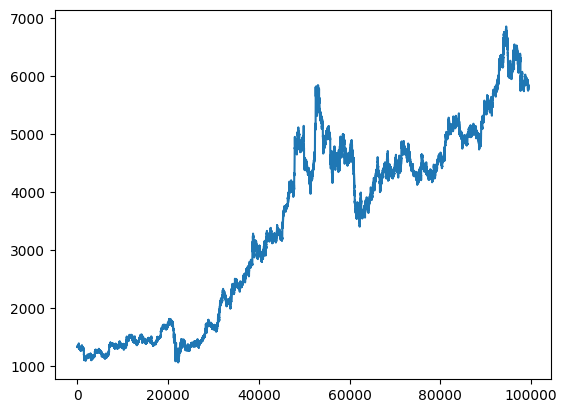

In [9]:
plt.plot(close)

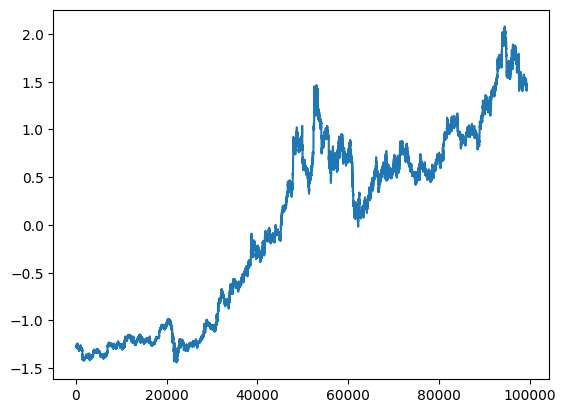

In [10]:
plt.plot(normed_close)


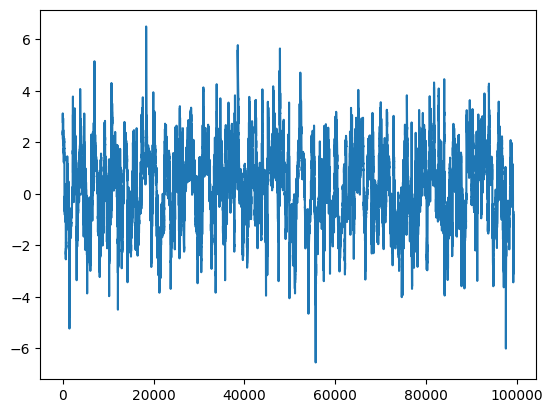

In [11]:
plt.plot(window_norm)

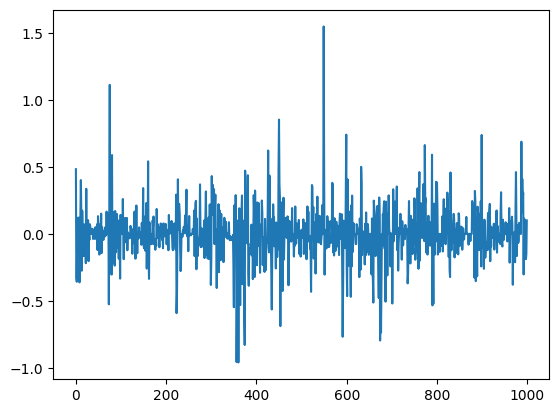

In [19]:
plt.plot(returns[:1000]*100)